In [ ]:
from skykatana import SkyMaskPipe
import healpy as hp, healsparse as hsp, pandas as pd, numpy as np, matplotlib.pyplot as plt
from matplotlib.patches import Polygon; from mocpy import MOC, WCS
from astropy.coordinates import Angle, SkyCoord; import astropy.units as u
from functools import partial; import lsdb

**First, excecute the HTML cell below to apply some CSS styles used thougout this notebook**

In [ ]:
%%html
<style>
/* Light theme */
body[data-jp-theme-light="true"] .met   { background-color: rgb(218, 229, 251);  color: rgb(27, 58, 121); padding:3px 3px; border:1px solid rgb(36, 138, 255);  border-radius:6px; }
body[data-jp-theme-light="true"] .icode { font-family: monospace; color: rgb(91, 151, 43); }
body[data-jp-theme-light="true"] .sc    { font-variant: small-caps; font-weight: bold; }
body[data-jp-theme-light="true"] .note  { display:inline-block; background-color: rgb(91, 144, 251); color:white; padding:6px; border-radius:6px; font-size:1em; }
body[data-jp-theme-light="true"] .callout { border-left:6px solid rgb(99,99,99); border-right:6px solid rgb(99,99,99); border-radius:6px;
                                            background: rgb(255, 255, 255); padding:8px 16px; font-size:1em; }
body[data-jp-theme-light="true"] .st    { color: rgb(162, 93, 93); padding:0 8px; font-weight:bold; border-radius:12px; border:1px solid rgb(247,94,94); }
/* Dark theme */
body[data-jp-theme-light="false"] .met   { background-color: rgb(39,51,61);  color: rgb(222,219,142); padding:3px 3px; border:1px solid rgb(78,115,128); border-radius:6px; }
body[data-jp-theme-light="false"] .icode { font-family: monospace; color: rgb(145,208,93); }
body[data-jp-theme-light="false"] .sc    { font-variant: small-caps; font-weight: bold; }
body[data-jp-theme-light="false"] .note  { display:inline-block; background-color: rgb(23,80,130); color:white; padding:6px; border-radius:6px; font-size:1em; }
body[data-jp-theme-light="false"] .callout { border-left:6px solid rgb(99,99,99); border-right:6px solid rgb(99,99,99); border-radius:6px;
                                             background: rgba(40,40,40,0.8); padding:8px 16px; font-size:1em; color: rgb(181, 181, 181);}
body[data-jp-theme-light="false"] .st    { color: rgb(255,255,255); padding:0 8px; font-weight:bold; border-radius:12px; border:1px solid rgb(247,94,94); }
</style>

# Creating Star Masks for Rubin in RSP with Skykatana
-----------------
Starting from an input catalog of sources, a list of geometric shapes, or any healsparse map, <span class="sc">Skykatana</span> can create a pixelized mask in healsparse format, excluding areas due to various effects such as bright stars, patches with low depth, extended sources, etc. <span class="sc">Skykatana</span> is also designed to create star masks on-demand in the Rubin Science Platform over thousands of deg<sup>2</sup> in just a few minutes with very limited memory resources, and even intersect masks from different surveys.

Basic usage: 
* <span class="met">build_foot_mask(), build_patch_mask(), build_circle_mask()</span>, etc. are used to produce individual masks <div style="height:0.5em;"></div>
* <span class="met">combine()</span> to merge the maps create above into a "final" mask <div style="height:0.5em;"></div>
* <span class="met">plot()</span> can quickly visualize a mask by plotting randoms, make zooms and overplot stars <div style="height:0.5em;"></div>
* <span class="met">plot_moc</span> to visualize a MOC version of a mask, with accurrate coordinate projections <div style="height:0.5em;"></div>
* <span class="met">makerans</span> to generate randoms over any mask <div style="height:0.5em;"></div>
* <span class="met">apply</span> to cut out sources outside of any given mask

When pixelating an input catalog of sources, <span class="sc">Skykatana</span>  accepts a pandas daframe, any data format readable by astropy, or a HATS catalog. In the latter case, pixelization can be distributed across workers to handle catalogs larger than available memory, such as Rubin.

For creating bright star masks, <span class="sc">Skykatana</span> has special methods to query and pixelate large online catalogs in HATS format (such as Gaia), that work in systems with limited memory resources.

Masks and their metadata are stored as **stages** in a **pipeline** class object that can be saved to disk
<br>
<div class="note">This notebook shows how to produce a mask for Vera Rubin data due to bright stars, by querying Gaia sources on-demand, calculating exclusion radii and pixelating circles. It is meant to be run in the Rubin Science Platform, although it will work anywhere as long as the catalog of stars being queried is available in HATS/LSDB format</div>

## 1. Define search area and create pipeline

<div class='callout'>First we have to define a seach area where to look for stars. While it can be any stage or boolean map, in Rubin it will be most likely some property map for example of coverage in a given band or total exposure time. In the following example, we select the NES (North Ecliptic Survey) area from the baseline 10-yr Rubin footprint and store it as the <span class='st'>nesmask</span> stage.</div>

In [ ]:
from rubin_scheduler.scheduler.utils import CurrentAreaMap
sag = CurrentAreaMap()
sky_maps, labels = sag.return_maps()

In [ ]:
sky_maps['r']

In [ ]:
np.unique(labels)

In [ ]:
hp.mollview(sky_maps['r'], title='Rubin r-band - Baseline 10yr')

In [ ]:
# Select NES pixels
idx, = np.where(labels=='nes')
idx[:10]

In [ ]:
# Create empty map and update pixel values 
m = hsp.HealSparseMap.make_empty(nside_coverage=2**3, nside_sparse=2**5, dtype=bool)
m.update_values_pix(idx, True, nest=False)

In [ ]:
# Initialize and store into a stage
mkp = SkyMaskPipe()
mkp.nesmask = m

<div class="callout"> Just type the instance name to display useful information like orders, valid pixels, area, etc.
</div>

In [ ]:
mkp

<div class="callout"> This is very low resolution! Upgrade sparse order before continuing to avoid some limitations in Healsparse when dealing with bit-packed maps.
</div>

In [ ]:
mkp.change_sparse_order(stage='nesmask', order=8);

In [ ]:
mkp

<div class="callout">Lets check how it looks in the sky</div>

In [ ]:
center = SkyCoord(90*u.deg, 16*u.deg)  ;  fov = 70*u.deg
fig, ax, wcs = mkp.plot_moc(stage='nesmask', center=center, fov=fov, figsize=[10,7], color='r', label='NES');
plt.legend();

In [ ]:
####  If you can't load Rubin Scheduler or get to the NES pixels, uncomment the following and load it from disk
#m = SkyMaskPipe.read_single('./auxfiles/nesmask.fits')
#mkp = SkyMaskPipe()
#mkp.nesmask = m

## 2. Define radius function and star query dictionary

<div class="callout">Now, we define the <span style='font-weight:bold'>radius function</span> that will assign an exclusion radius around the stars. This function, which will passed to SkyKatana, can be completely customized with the only requirement that it must take an input dataframe (e.g. with star magnitudes) and add a "radius" column (in deg) for each row element. In the toy example below, <span class='met'>radfunction()</span> can be customized according to completeness level and desired band.</div>

In [ ]:
def radfunction(df: pd.DataFrame, **kwargs):
    mag = 'phot_g_mean_mag'                          # define magnitude to use
    band = kwargs.get('band', 'r')                   # extract band
    completeness = kwargs.get('completeness', 0.85)  # extract completeness level
    if band == 'r':
        if completeness==0.85:
            nconst1, alpha1 = (116138.9,-0.7489)  # normalization constant and exponential slope alpha
            magcut        =  11.158        # magnitude cutoff above which stars get a fixed faint_radius
            nconst2, alpha2 = (113.6743,-0.1279)  # normalization constant and exponential slope alpha
        elif completeness==0.90:
            nconst, alpha = (1318.6,-0.28)  # normalization constant and exponential slope alpha
            magcut        =  17.24          # magnitude cutoff above which stars get a fixed faint_radius
            faintrad      =  10.8           # faint radius [arcsec]            
    # Set radius
    df['radius'] = np.where(df[mag] <= magcut, nconst1*np.exp(alpha1*df[mag])/3600., nconst2*np.exp(alpha2*df[mag])/3600.)

<div class='callout'>Now we define the <span style='font-weight:bold'>star query dictionary</span>. This controls where and which stars will be queried, as well as some performance parameters to keep memory usage under control. If the area searched is very large, Skykatana can break it into chunks that are queried, processed and coadded at the end, thus enabling procesing of thousands of deg<sup>2</sup>.</div>

In [ ]:
starq = {'search_stage': mkp.nesmask,                  # The stage where we want to retrieve stars
         'cat':"./gaiaNES",                            # URL of HATS catalog, e.g. for Gaia
         'columns':['ra','dec','phot_g_mean_mag'],     # Columns to retrieve from it
         'gaia_gmag_lims':[8,20],                      # G_band magnitude limits
         'radfunction': partial(radfunction, completeness=0.85, band='r'),  # Star radius function. Must be wrapped with partial()
         'avoid_mw': True,                             # Avoid Milky Way plane & bulge
         'b0_deg': 15.,                                # Mikly Way plane zone of exclusion from -b to b (deg)
         'bulge_a_deg': 25.,                           # Milky Way bulge semimajor axis length (deg)  
         'bulge_b_deg': 20.,                           # Milky Way bulge semiminor axis length (deg)
         'max_area_single': 800.,                         # Optional - max area to make in a single query
         'target_chunk_area': 800.,                       # Optional - target area of chunks that the search_stage is splitted into
         'coarse_order_bfs': 5                            # Optional - coarse order to perform chunking
         }

<div class='callout'>Large-scale queries might accidentally go deep into the Milky Way plane or bulge, stressing database systems and leading to memory issues or failed searches. To prevent this, when <span class='icode'>avoid_mw=True</span> SkyKatana will create a MOC map of the galaxy following the given parameters for the plane and (elliptical) bulge, and subtract if <span style='font-weight:bold'>before</span> searching for stars. In addition, the galaxy mask will get stored in the <span class='st'>mwmask</span> in case you need to combine it with other stages.</div>

<div class="note">Note that the stars returned will always follow the search stage minus the galaxy mask, if chosen so, but the search stage in the pipeline remains untouched. Subtract <span class='st'>mwmask</span> from that or any other stage, when needed.</div>

## 3. Search stars, construct its mask and plot

<div class='callout'>Before searching, we should start the Dask client to set the number of workers and memory resources. </div>

In [ ]:
from dask.distributed import Client
client = Client(n_workers=3, threads_per_worker=1, memory_limit="6GiB")

In [ ]:
client

<div class='callout'>We have everything ready. Just choose the orders for pixelization and run</div>

In [ ]:
mkp.build_star_mask_online(starq=starq, order_sparse=15, order_cov=5, n_threads=6);

In [ ]:
#### If the processes failed, run this to read back the mkp pipeline from disk
#mkp = SkyMaskPipe.read('./nes/')

<div class='callout'>Verify a new stage <span class='st'>starmask</span> has been created and check how it looks. It is clear that the empty zone at about ra=268 deg is due to the Milky Way mask</div>

In [ ]:
mkp

In [ ]:
center = SkyCoord(90*u.deg, 16*u.deg)  ;  fov = 70*u.deg
fig, ax, wcs = mkp.plot_moc(stage='starmask', center=center, fov=fov, figsize=[10,7], color='b', label='starmask');
plt.legend();

<div class='callout'>Make a zoom to clearly see what the mask is made of. Use a smaller field of view and, <span style='color:red'>very important</span>, clip the data outside the viewing regions to increase performance</div>

In [ ]:
center = SkyCoord(130.5*u.deg, 20.5*u.deg)  ;  fov = 1*u.deg
clipra  = [130., 131.]
clipdec = [20., 21.]
fig, ax, wcs = mkp.plot_moc(stage='starmask', center=center, fov=fov, figsize=[7,7], label='starmask', color='b',
                            clipra=clipra, clipdec=clipdec)
plt.legend();

<div class='callout'>There is also new stage <span class='st'>mwmask</span> due to the Milky Way mask</div>

In [ ]:
center = SkyCoord(70*u.deg, 0*u.deg)  ;  fov = 130*u.deg
fig, ax, wcs = mkp.plot_moc(stage='starmask', center=center, fov=fov, figsize=[10,7], color='b', label='starmask', projection='AIT');
fig, ax, wcs = mkp.plot_moc(stage='mwmask', center=center, fov=fov, ax=ax, wcs=wcs, color='y', label='mkwmask');
plt.legend();

### Saving stars

<div class="callout"><span class="sc">Skykatana</span> can also save the stars queried by setting <span class='icode'>save_stars=True</span>. This will save the stars of each chunk (with radius added) as a series of files stars_chunk_01.parquet, stars_chunk_02.parquet, etc.</div>

<div class="callout">Note however there will be repeated stars. This is because by construction the MOCs of each part are enlarged along their borders to include the effect of stars slighly outside their own area. If you need a unique list, apply a simple deduplication algorithm by ra-dec position.</div>

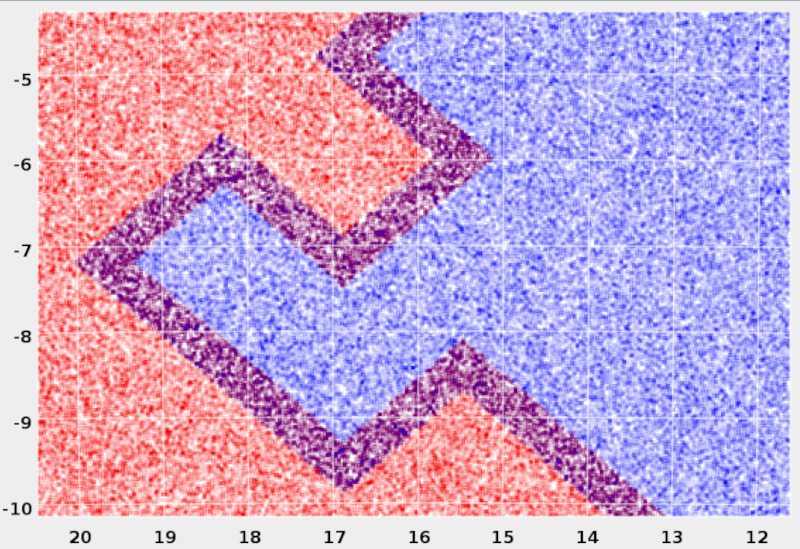

## 4. Combine and save to disk

<div class="callout">In <span class="sc">Skykatana</span>, the <span class='met'>combine()</span> method can easily subtract the area vetted by bright star from the input <span class='st'>propmask</span>. Note we also subtract  <span class='st'>mwmask</span> to mask out the galaxy in our original stage. The resulting <span class='st'>mask</span> stage now holds the "postive" area remaining.</div>

In [ ]:
mkp.combine(positive=['nesmask'], negative=['starmask', 'mwmask'], order_out=15, order_cov=5);

In [ ]:
mkp

<div class="callout">Lets check this combined mask by plotting a zoomed MOC</div>

In [ ]:
center = SkyCoord(130.5*u.deg, 20.5*u.deg)  ;  fov = 1*u.deg
clipra  = [130., 131.]
clipdec = [20., 21.]
fig, ax, wcs = mkp.plot_moc(stage='mask', center=center, fov=fov, figsize=[7,7], label='mask', color='g',
                            clipra=clipra, clipdec=clipdec)
plt.legend();

<div class="callout">Since we are happy with the results, save the pipeline to disk. This will create a directory where each stage is saved in FITS format using bit-encoding compression, plus a JSON file holding various metadata</div>

In [ ]:
# Write the entire mask in a single statement
mkp.write('./nes', overwrite=True)

In [ ]:
client.close()
del mkp

In [ ]:
# If you can't reproduce the mask, read it back from disk
mkp = SkyMaskPipe.read('./nes')

## 5. Interactive plots

<div class='callout'><span class="sc">Skykatana</span> can also generate interactive plots of mask MOCs, by leveraging the capabilities of the <a href="https://github.com/cds-astro/ipyaladin" target="_blank">ipyaladin widget</a> available for Jupyter</div>

<div class='callout'>In this example, we overlay our <span class='st'>starmask</span> over the Gaia density map. The starmask is degraded to order 13 at the expense of washing out small circles, but useful to speed up large-scale visualizations. Note how the search has avoided the galactic plane and bulge because we set <span class='icode'>avoid_mw=True</span></div>

In [ ]:
# Enable interactive widget -> get pan/zoom and pixel values when hovering the mouse 
# Should have installed ipympl and ipywidgets
%matplotlib widget

In [ ]:
alawidget = mkp.plot_moca(mkp.nesmask, order_forced=8)

<div class='callout'>Below is screen capture of the widget you should be seeing, with a mask MOC loaded</div>

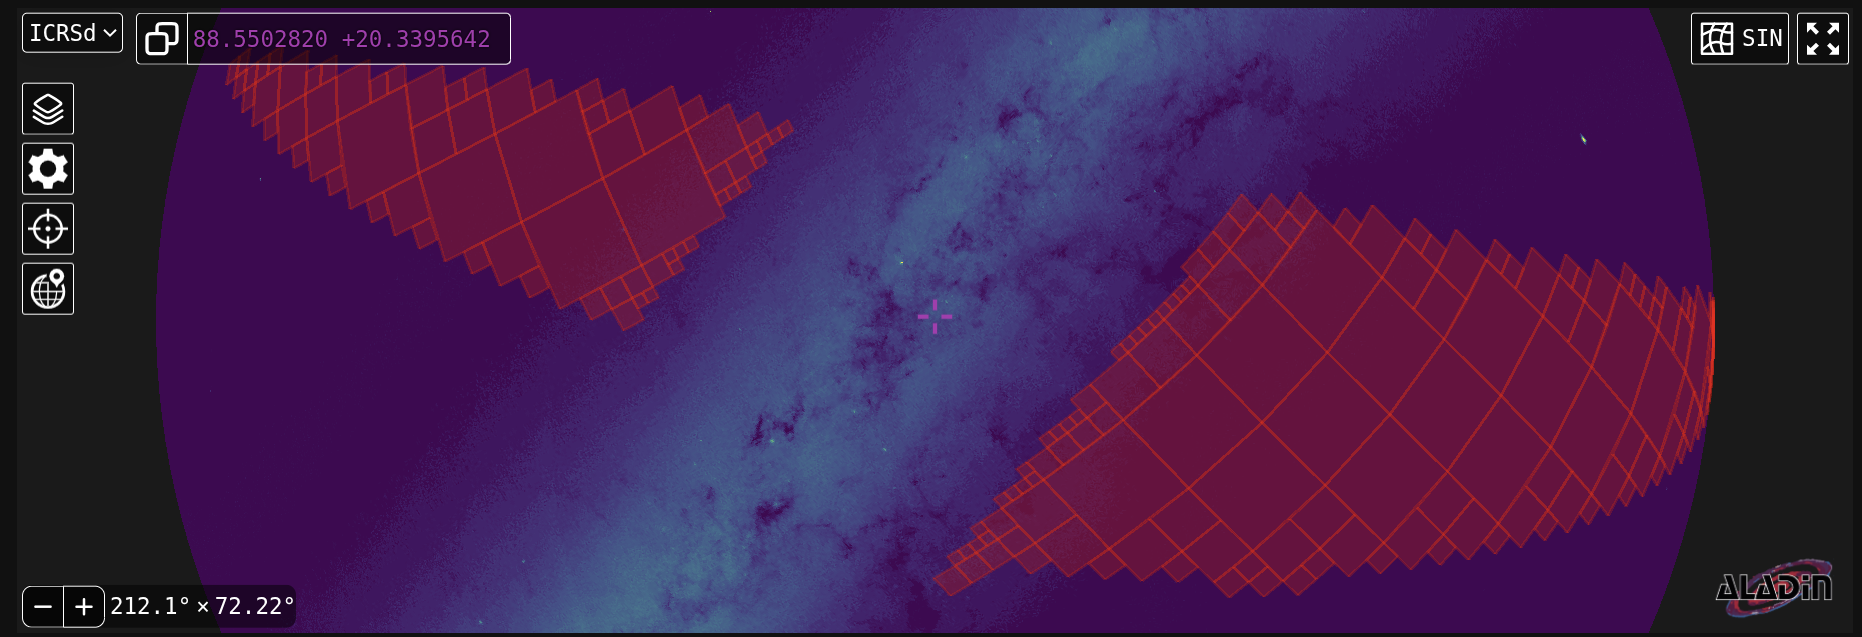

<div class='callout'>You can continue adding stages to the same widet with <span class='met'>add_moca()</span></div>

<div class='note'>It is not recommended to attemp interactive visualizations of very large masks (thousands of sq degrees) with high orders (15-16), as the widget will receive a huge MOC and might become unresponsive. Best practice is to force a low order first, and then rise it untill results are statisfactory.</div>

## 6. Fractional area maps

<div class='callout'>When investigating the effect of stars and other sources, a useful statistical measure is the fractional area masked out. That is, for a given order, the fractional area is the fraction of sparse pixels masked by those objects. For example, in dense regions near the galatic plane the number of pixels "occupied" by stars can be so high that this fraction can approach values close to one. In constrast, zones away from crowded stellar fields typically show fractions from 0.1-0.3 for a reasonable parametrization of the masking radius of stars.</div>

<div class='callout'>Healsparse provides a very efficient method to estimate these fractions. Based on it, <span class="sc">Skykatana</span> implements a convenient method (<span class='met'>frac_area_map()</span>), that optionally replaces the pixel around edges, which by construction
have sistematically lower fractions, by the local harmonic mean values. The result is a map whose (floating point) value is between 0 and 1. For visualiztion, <span class='met'>plot_fracmap()</span> can automatically calculate the fractional map of any stage, generate its 2D image representation, and overlay it over a WCS axes with optional contour levels.</div>

In [ ]:
%matplotlib inline

In [ ]:
center = SkyCoord(90*u.deg, 20*u.deg)  ;  fov = 90*u.deg
fig, ax, wcs, im, cs = mkp.plot_fracmap(stage='starmask', center=center, fov=fov, figsize=[12,8], avg_edges=True,
                                       thresholds=[0.3,0.5], contour_smooth={'method':'gaussian', 'sigma_pix':3.0})

<div class='note'>Tip: if you install and enable the ipympl interative Jupyter backend, hovering the mouse over the image will show interactively the value of the fractional map.</div>

<div class='callout'>Once you find a threshold suitable for the mask purpose, just use <span class='met'>build_prop_mask()</span> to construct a mask</div>

In [ ]:
frac = SkyMaskPipe.frac_area_map(mkp.starmask, order_frac=6, avg_edges=True)
mkp.build_prop_mask(prop_maps=[frac],thresholds=[0.3],comparisons=['lt'],output_stage='goodmask', order_sparse=6, order_cov=5)

<div class='callout'>And visualize everthing together</div>

In [ ]:
center = SkyCoord(90*u.deg, 20*u.deg)  ;  fov = 90*u.deg
fig, ax, wcs, im, cs = mkp.plot_fracmap(stage='starmask', center=center, fov=fov, figsize=[12,8], order_frac=8, avg_edges=True)
fig, ax, wcs = mkp.plot_moc(stage='goodmask', center=center, fov=fov, ax=ax, wcs=wcs, color='r', alpha=0.7, order_force=6)

In [ ]:
center = SkyCoord(137*u.deg, 25*u.deg)  ;  fov = 40*u.deg
fig, ax, wcs, im, cs = mkp.plot_fracmap(stage='starmask', center=center, fov=fov, figsize=[12,8], order_frac=8, avg_edges=True)
fig, ax, wcs = mkp.plot_moc(stage='goodmask', center=center, fov=fov, ax=ax, wcs=wcs, color='r', alpha=0.7, order_force=6)

<div class='callout'>Refine this mask a little more. We went down in order to take advantage of the averaging, so lets go back to the order of the search stage.</div>

In [ ]:
mkp.change_sparse_order(stage='goodmask', order=12, inplace=True)

<div class='callout'>And intersect this goodmask with the search stage while subtracting the Milky Way mask. This will get rid of the peaks of the coarser fractional map around the edges while preserving a "smooth" trasition across the threshold boundary.</div>

In [ ]:
mkp.combine(positive=[('nesmask','goodmask')], negative=['mwmask'], order_out=12, order_cov=5, output_stage='bettermask')

In [ ]:
center = SkyCoord(137*u.deg, 25*u.deg)  ;  fov = 40*u.deg
fig, ax, wcs = mkp.plot_moc(stage='nesmask', center=center, fov=fov, figsize=[12,8], color='g', order_force=12)
fig, ax, wcs = mkp.plot_moc(stage='bettermask', ax=ax, wcs=wcs, color='r', alpha=0.6, order_force=12)

## 7. Bonus: play with some funny masks

<div class='callout'><span class="sc">Skykatana</span> has a funny side too. It includes algorithms to draw any picture with healpix pixels on the sky! Below, we will perform the much desired Rubin-Roman intersection.</div>

In [ ]:
# Make Rubin map
rubin_map = SkyMaskPipe.image_to_healsparse("./auxfiles/rubinobs.jpg",
    order_sparse=11, order_cov=4,      # orders         
    ra0_deg=0.0, dec0_deg=-20.0,       # ra-dec of center
    width_deg=40.0, rotation_deg=0.0,  # height inferred from the image aspect ratio
    invert=True,                       # set True if the figure is dark on a bright background
    blur_radius=0.0,                   # try 1–2 px if edges are noisy
    threshold=None,                    # use Otsu; or set e.g. 128 manually
    expand_px=1,                       # dilate lines by N pixels (helps thin features)
    samples_per_pix=4,                 # nicer edges; use 1 for speed
    edge_eps=0.0,                      # small (e.g., 0.01) to slightly thicken
    chunk_size=50_000, return_bit_packed=False )

In [ ]:
# Make Roman map
roman_map = SkyMaskPipe.image_to_healsparse("./auxfiles/roman.jpg",          #
    order_sparse=11, order_cov=4,      # orders  
    ra0_deg=7, dec0_deg=-18.0,         # ra-dec of center
    width_deg=37.0, rotation_deg=0,    # height inferred from the image aspect ratio
    invert=True,                       # set True if the figure is dark on a bright background
    blur_radius=0.0,                   # try 1–2 px if edges are noisy
    threshold=None,                    # use Otsu; or set e.g. 128 manually
    expand_px=1,                       # dilate lines by N pixels (helps thin features)
    samples_per_pix=4,                 # nicer edges; use 1 for speed
    edge_eps=0.0,                      # small (e.g., 0.01) to slightly thicken
    chunk_size=50_000, return_bit_packed=False)

<div class='callout'>Put them in a pipeline and get intersection</div>

In [ ]:
funpipe = SkyMaskPipe()
funpipe.rubinmask = rubin_map
funpipe.romanmask = roman_map
funpipe.combine(positive=[('rubinmask','romanmask')], order_out=11, order_cov=4);

<div class='callout'>Plot their MOCs and enjoy !</div>

In [ ]:
center = SkyCoord(0*u.deg, -20*u.deg)  ;  fov = 41*u.deg
fig, ax, wcs = funpipe.plot_moc(stage='rubinmask', center=center, fov=fov, figsize=[8,8], label='LSST DR1', color='b', order_force=11)
fig, ax, wcs = funpipe.plot_moc(stage='romanmask', center=center, fov=fov, figsize=[8,8], label='ROMAN DR1', color='r', order_force=11, ax=ax, wcs=wcs)
fig, ax, wcs = funpipe.plot_moc(stage='mask', center=center, fov=fov, figsize=[8,8], label='intersection mask', color='k', order_force=11, ax=ax, wcs=wcs)
plt.legend();

<div class='callout'>Just for the sake of practice, lets drill the holes due to stars in this precious area</div>

In [ ]:
starq = {'search_stage': funpipe.mask,                 # The stage where we want to retrieve stars
         'cat':"../gaiapiece/",                        # URL of HATS catalog, e.g. for Gaia
         'columns':['ra','dec','phot_g_mean_mag'],     # Columns to retrieve from it
         'gaia_gmag_lims':[7,18],                      # G_band magnitude limits
         'radfunction': partial(radfunction, completeness=0.85, band='r'),  # Star radius function. Must be wrapped with partial()
         'avoid_mw': True,                            # Avoid Milky Way plane & bulge
         'b0_deg': 15.,                                # Mikly Way plane zone of exclusion from -b to b (deg)
         'bulge_a_deg': 25.,                           # Milky Way bulge semimajor axis length (deg)  
         'bulge_b_deg': 20.,                           # Milky Way bulge semiminor axis length (deg)
         'max_area_single': 400.,                         # Optional - max area to make in a single query
         'target_chunk_area': 400.,                       # Optional - target area of chunks that the search_stage is splitted into
         'coarse_order_bfs': 5                            # Optional - coarse order to perform chunking
         }

In [ ]:
funpipe.build_star_mask_online(starq=starq, n_threads=1);

In [ ]:
# Subtract the star mask from the previous (intersection) mask
funpipe.combine(positive=['mask'], negative=['starmask'], order_out=15, order_cov=4)

In [ ]:
# Plot the new golden mask!
center = SkyCoord(3*u.deg, -20*u.deg)  ;  fov = 21*u.deg
fig, ax, wcs = funpipe.plot_moc(stage='mask', center=center, fov=fov, figsize=[8,8], label='golden mask', color='g')
plt.legend();

In [ ]:
# Plot the new golden mask!
center = SkyCoord(3*u.deg, -20*u.deg)  ;  fov = 5*u.deg 
clipra = [3-0.5*5, 3+0.5*5.]
clipdec = [-20-0.5*5, -20+0.5*5]
fig, ax, wcs = funpipe.plot_moc(stage='mask', center=center, fov=fov, figsize=[8,8], label='golden mask', color='g', 
                                clipra=clipra, clipdec=clipdec)
plt.legend();

In [ ]:
funpipe